# Final Project: Used Vehicle Price Predictor - EDA and Pre-processing
### Author: Satish Agrawal, Sanjay Jaras
### Bellevue University
### DSC 630 - Predictive Analytics

The price of the new vehicle is determined by the manufacturer. The manufacturer considers a variety of factors including government taxes, used raw materials cost, the labor involved, intended profit margin per unit, and many other factors that may contribute to the price of the car to come up with the Manufacturer Suggested Retail Price (MSRP). So, buyers of new cars are a bit more confident about the price of new cars; which is not always true with the price of an old car. The used car buying is a very complex process, as an average buyer might not think of all the variables affecting or involved in the price of the vehicle. 

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv
import types
import seaborn as sns

from sklearn import __version__ as sklv
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor,LocalOutlierFactor
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, BayesianRidge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from tqdm import tqdm

In [3]:
print('Using version %s of pandas' % pd.__version__)
print('Using version %s of numpy' % np.__version__)
print('Using version %s of matplotlib' % mpv)
print('Using version %s of seaborn' % sns.__version__)
print('Using version %s of sklearn' % sklv)
print('Using version %s of geopandas' % gpd.__version__)

Using version 1.2.0 of pandas
Using version 1.19.2 of numpy
Using version 3.3.2 of matplotlib
Using version 0.11.1 of seaborn
Using version 0.24.0 of sklearn
Using version 0.8.2 of geopandas


## Configurations


In [4]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)
import warnings
warnings.filterwarnings('ignore')

## Load Data
Load data downloaded from https://www.kaggle.com/austinreese/craigslist-carstrucks-data into a dataframe


In [5]:
org_df = pd.read_csv("vehicles.csv", index_col=[0], converters={"cylinders":str}, parse_dates=["posting_date"])

### Show summary
Show dataframe information along with number of entries and datatype for each column in dataframe

In [6]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458213 entries, 0 to 458212
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            458213 non-null  int64  
 1   url           458213 non-null  object 
 2   region        458213 non-null  object 
 3   region_url    458213 non-null  object 
 4   price         458213 non-null  int64  
 5   year          457163 non-null  float64
 6   manufacturer  439993 non-null  object 
 7   model         453367 non-null  object 
 8   condition     265273 non-null  object 
 9   cylinders     458213 non-null  object 
 10  fuel          454976 non-null  object 
 11  odometer      402910 non-null  float64
 12  title_status  455636 non-null  object 
 13  transmission  455771 non-null  object 
 14  VIN           270664 non-null  object 
 15  drive         324025 non-null  object 
 16  size          136865 non-null  object 
 17  type          345475 non-null  object 
 18  pain

### update "posting_date" data type to date.
Converting posting_date column data type to date so that can be used with datetime operation

In [7]:
org_df["posting_date"]=pd.to_datetime(org_df.posting_date, utc=True)

#### Show dataframe contents

In [8]:
org_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02 14:11:30+00:00
1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02 08:11:50+00:00
2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-02 01:50:41+00:00
3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01 21:54:45+00:00
4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01 18:53:56+00:00


### Split Dataset into training and test set
Dataset splitted into 80-20, only 80% of data will be used for EDA and training

* train_set is used for EDA and testing outlier removals and transformation(Label Encoding and imputing)
* train_set_copy will be used for final pipeline testing and training the model.

In [9]:
train_set, test_set = train_test_split(org_df, test_size=0.2, random_state=random_state)
train_set_copy = train_set.copy()

In [10]:
print("Shape of training set:", train_set.shape)
print("Shape of test set:", test_set.shape)

Shape of training set: (366570, 25)
Shape of test set: (91643, 25)


### Training dataset information

In [11]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366570 entries, 341103 to 64753
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   id            366570 non-null  int64              
 1   url           366570 non-null  object             
 2   region        366570 non-null  object             
 3   region_url    366570 non-null  object             
 4   price         366570 non-null  int64              
 5   year          365708 non-null  float64            
 6   manufacturer  351930 non-null  object             
 7   model         362709 non-null  object             
 8   condition     212093 non-null  object             
 9   cylinders     366570 non-null  object             
 10  fuel          363991 non-null  object             
 11  odometer      322230 non-null  float64            
 12  title_status  364542 non-null  object             
 13  transmission  364656 non-null  object   

### We will not be using following columns as they are not related to vehicle price
* url
* id
* image_url
* description
* region_url
* VIN

### Create list of numeric and categorical attributes

In [12]:
num_attr = ["year", "odometer", "lat", "long"]
cat_attr = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size", "paint_color", "state", "type"]

### Pair plot for numeric variables

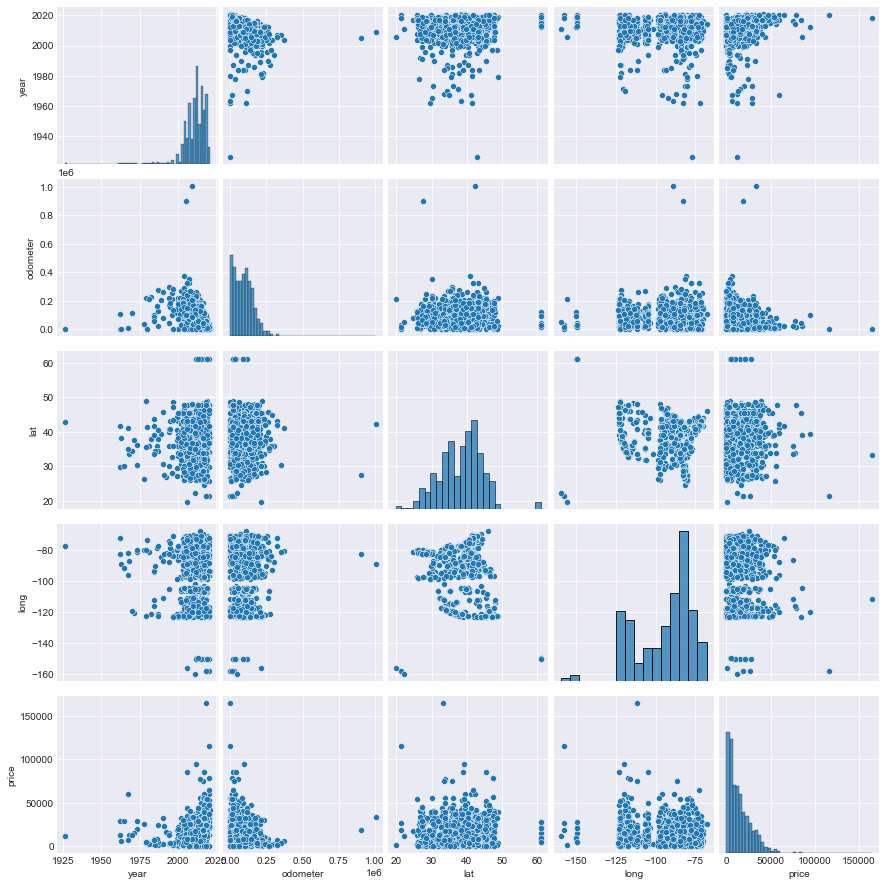

In [13]:
# added target variable price with numeric attributes
sns.pairplot(train_set[np.append(num_attr, "price")].head(1000))

### Plot by lat long

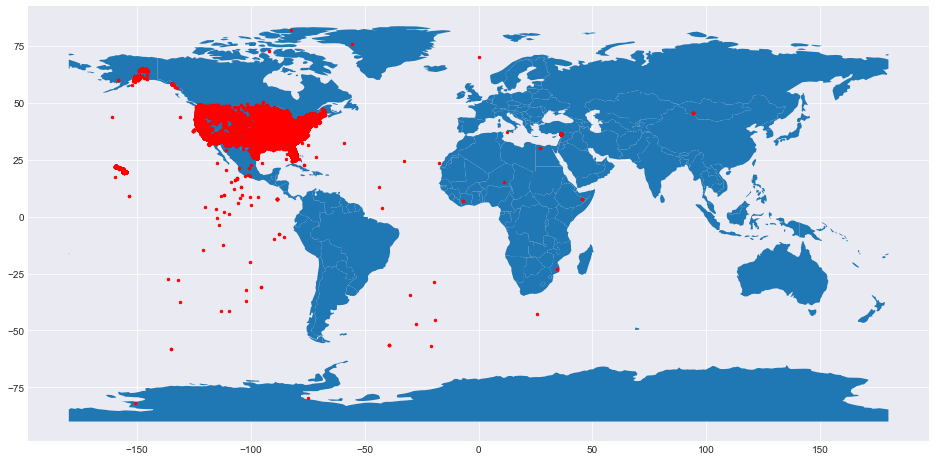

In [14]:
geometry = [Point(xy) for xy in zip(train_set['long'], train_set['lat'])]
gdf = GeoDataFrame(train_set, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 8)), marker='o', color='red', markersize=6);

We will consider data only from United States. So we will remove data out side United States.

### After removing outliers for lat long

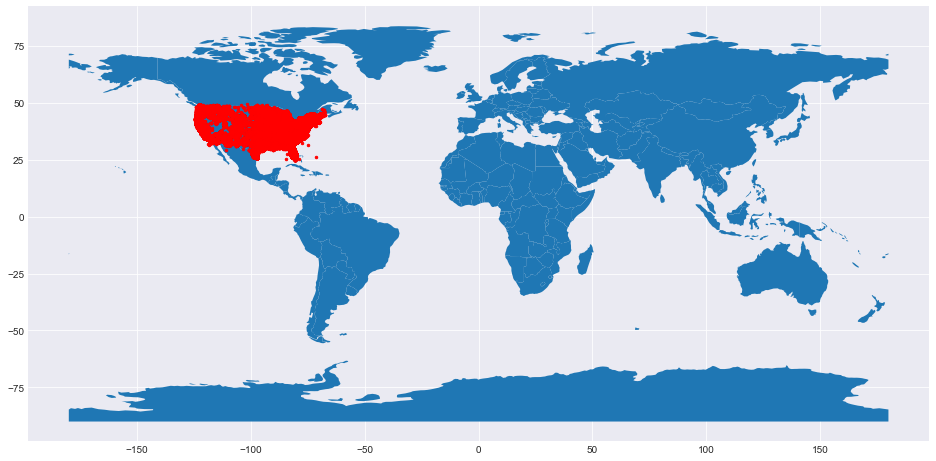

In [15]:
df = train_set[(train_set.lat>=25) & (train_set.lat<=50) & (train_set.long<=-65) & (train_set.long>=-125)]
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 8)), marker='o', color='red', markersize=6);

### Price by Fuel Type

Text(0.5, 1.0, 'Price by Fuel Type')

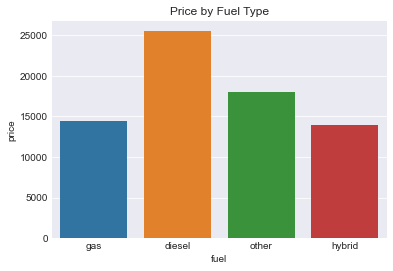

In [16]:
fig,axs=plt.subplots()
p1=sns.barplot(data=train_set.head(1000), x='fuel',y='price', ci=0, ax=axs)
axs.set_title('Price by Fuel Type')

### Price by Condtion

Text(0.5, 1.0, 'Price by condition')

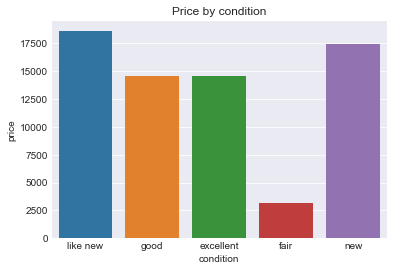

In [17]:
fig,axs=plt.subplots()
p1=sns.barplot(data=train_set.head(1000), x='condition',y='price', ci=0, ax=axs)
axs.set_title('Price by condition')

### Price by Make

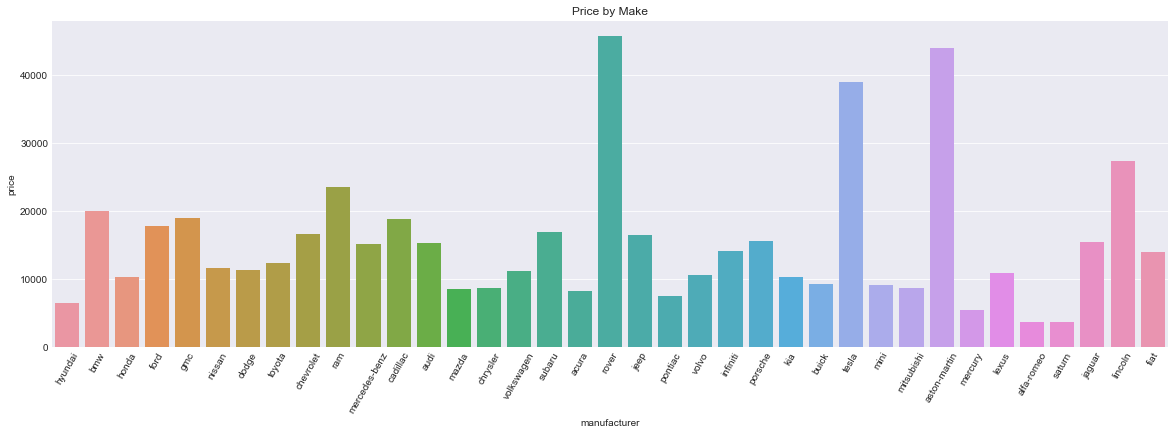

In [18]:
plt.figure(figsize=(20,6))
p1=sns.barplot(data=train_set.head(1000), x='manufacturer',y='price', ci=0)
plt.xticks(rotation=60)
plt.title("Price by Make")
plt.show()

Price by Model Year

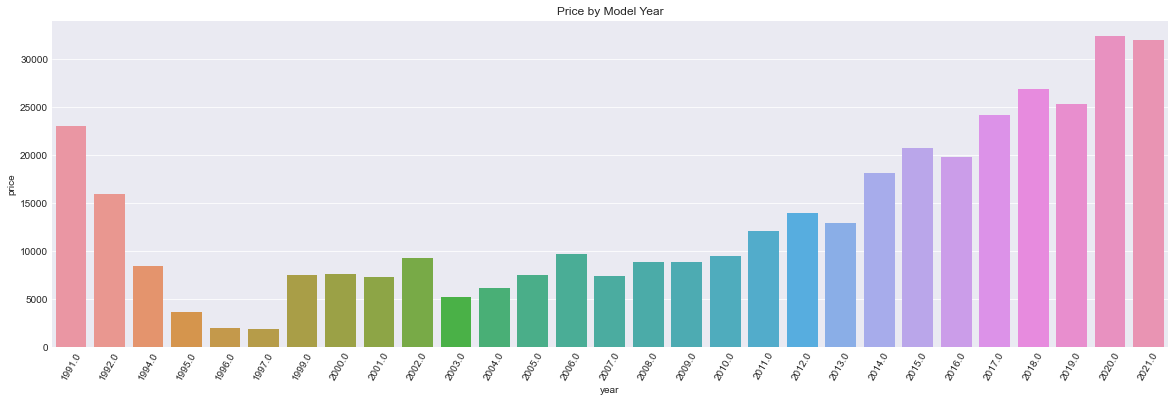

In [19]:
plt.figure(figsize=(20,6))
sns.barplot(data=train_set[train_set.year>1990].head(1000), x='year',y='price', ci=0)
plt.xticks(rotation=60)
plt.title("Price by Model Year")
plt.show()

### Price by Fuel Type and Condition

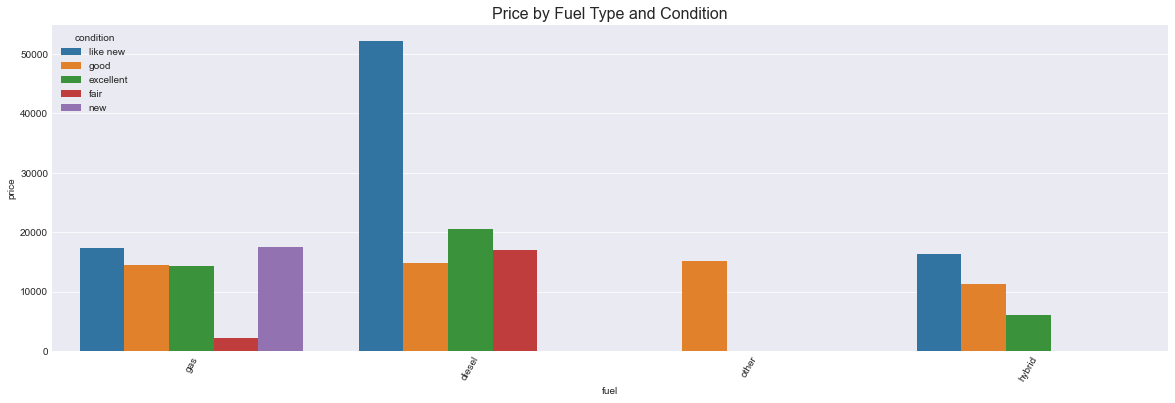

In [20]:
plt.figure(figsize=(20,6))
sns.barplot(data=train_set.head(1000), x='fuel',y='price',hue='condition', ci=0)
plt.xticks(rotation=60)
plt.title("Price by Fuel Type and Condition", fontsize=16)
plt.show()

### Create Class for outlier extraction to be used in pipeline
This class will take lower and upper limit values and will remove outlier records using these limits.

In [21]:
class OutlierExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, attrmap ):
        self.attrmap = attrmap

    def transform(self, df):
        X = df.copy()
        for attr in self.attrmap:
            val = self.attrmap[attr]
            #min, max = X[attr].quantile([val[0], val[1]])
            min, max = val[0], val[1]
            X = X[(X[attr]>=min) & (X[attr]<=max)]
        return X

    def fit(self, X, y = None):
        return self

### Check distribution and outlier for year column

In [22]:
train_set.year.describe()

count    365708.000000
mean       2010.745543
std           8.875581
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2016.000000
max        2021.000000
Name: year, dtype: float64

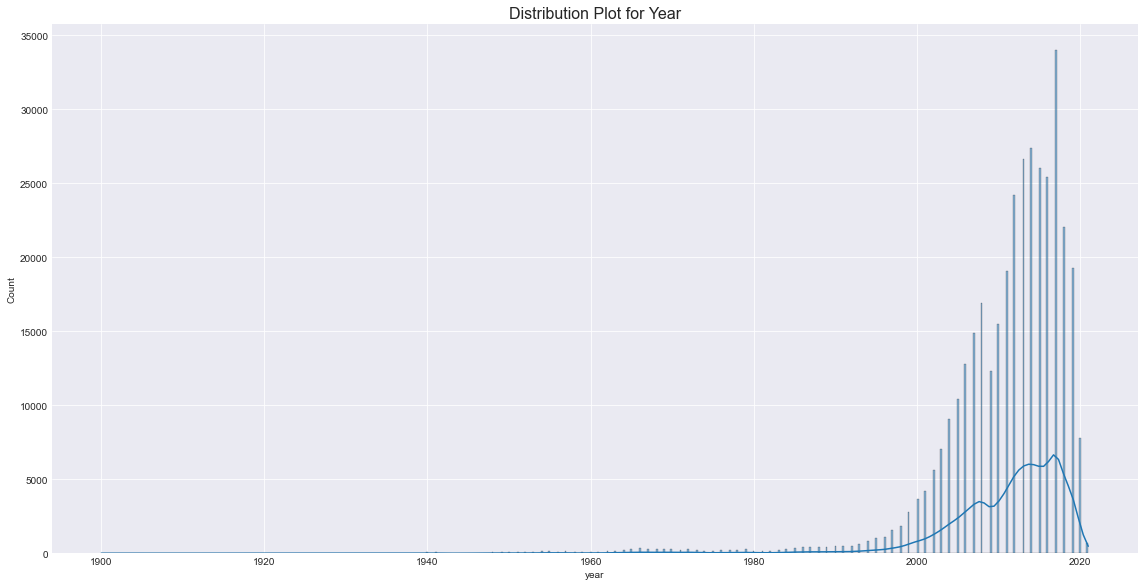

In [23]:
sns.displot(x=train_set.year, kde=True, height=8, aspect=2 )
plt.title("Distribution Plot for Year", fontsize=16)
plt.show()

### Drop outlier year records older than 1990 and newer than 2021

In [24]:
est = OutlierExtraction({"year":[1990, 2021]})
train_set = est.fit_transform(train_set)

### Year distribution after outlier removal

In [25]:
train_set.year.describe()

count    356351.000000
mean       2011.795300
std           5.653006
min        1990.000000
25%        2008.000000
50%        2013.000000
75%        2016.000000
max        2021.000000
Name: year, dtype: float64

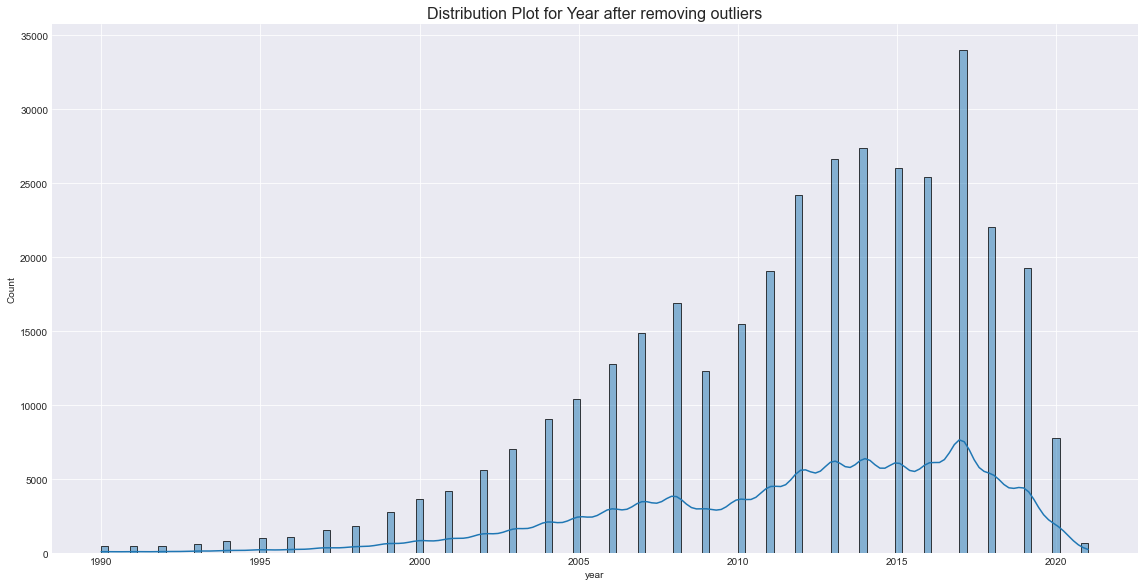

In [26]:
sns.displot(x=train_set.year, kde=True, height=8, aspect=2 )
plt.title("Distribution Plot for Year after removing outliers", fontsize=16)
plt.show()

### Check distribution and outlier for odometer

In [27]:
train_set.odometer.describe()

count    3.157770e+05
mean     1.028316e+05
std      3.645318e+06
min      0.000000e+00
25%      4.127100e+04
50%      8.823400e+04
75%      1.348010e+05
max      2.043756e+09
Name: odometer, dtype: float64

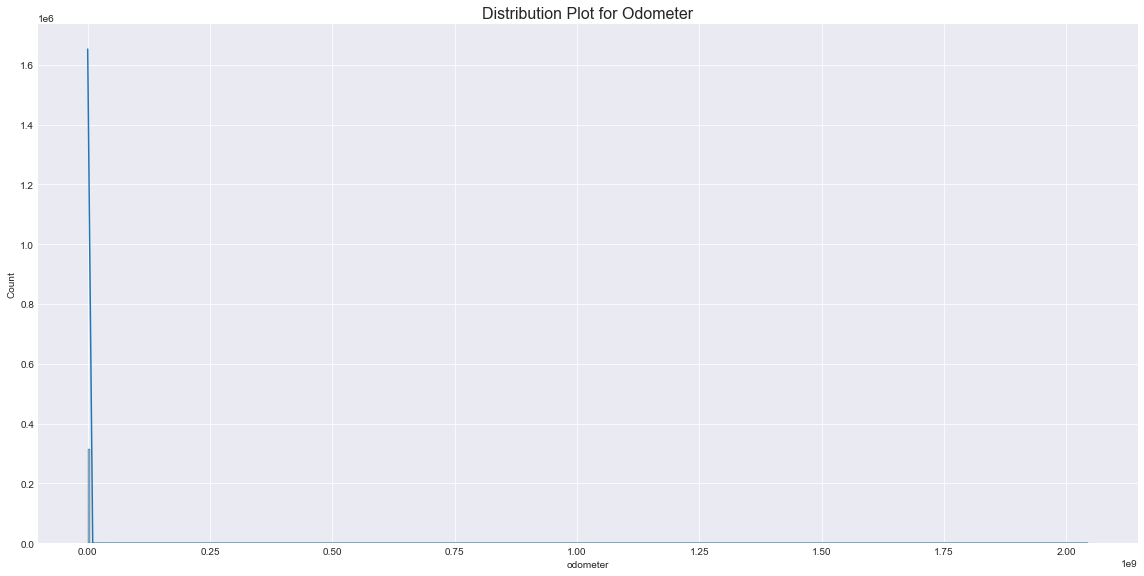

In [28]:
sns.displot(x=train_set.odometer, kde=True,  height=8, bins=500, aspect=2 )
plt.title("Distribution Plot for Odometer", fontsize=16)
plt.show()

### Drop records with outlier odometer, records with odometer greater than 170,000(around 90% of the data)

In [29]:
est = OutlierExtraction({"odometer":[0, 170_000]})
train_set = est.fit_transform(train_set)

In [30]:
train_set.odometer.describe()

count    278995.000000
mean      78355.557967
std       47251.788371
min           0.000000
25%       36715.000000
50%       77681.000000
75%      116960.000000
max      170000.000000
Name: odometer, dtype: float64

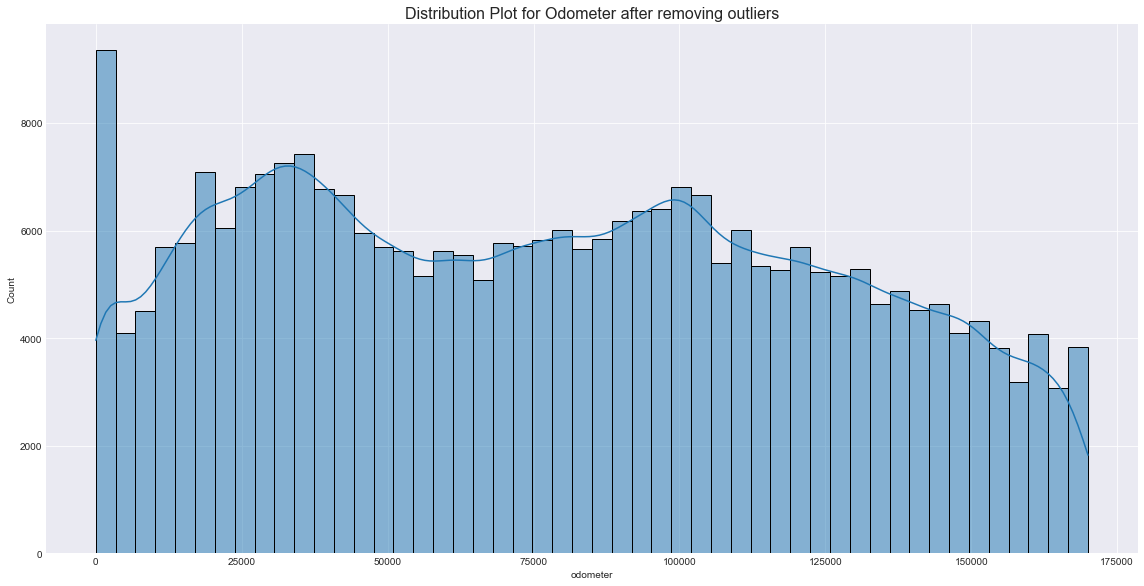

In [31]:
sns.displot(x=train_set.odometer, kde=True,  height=8, bins=50, aspect=2 )
plt.title("Distribution Plot for Odometer after removing outliers", fontsize=16)
plt.show()

### Check distribution and outlier for price

In [32]:
train_set.price.describe()

count    2.789950e+05
mean     3.033341e+04
std      6.851081e+06
min      0.000000e+00
25%      6.000000e+03
50%      1.299900e+04
75%      2.399000e+04
max      3.615215e+09
Name: price, dtype: float64

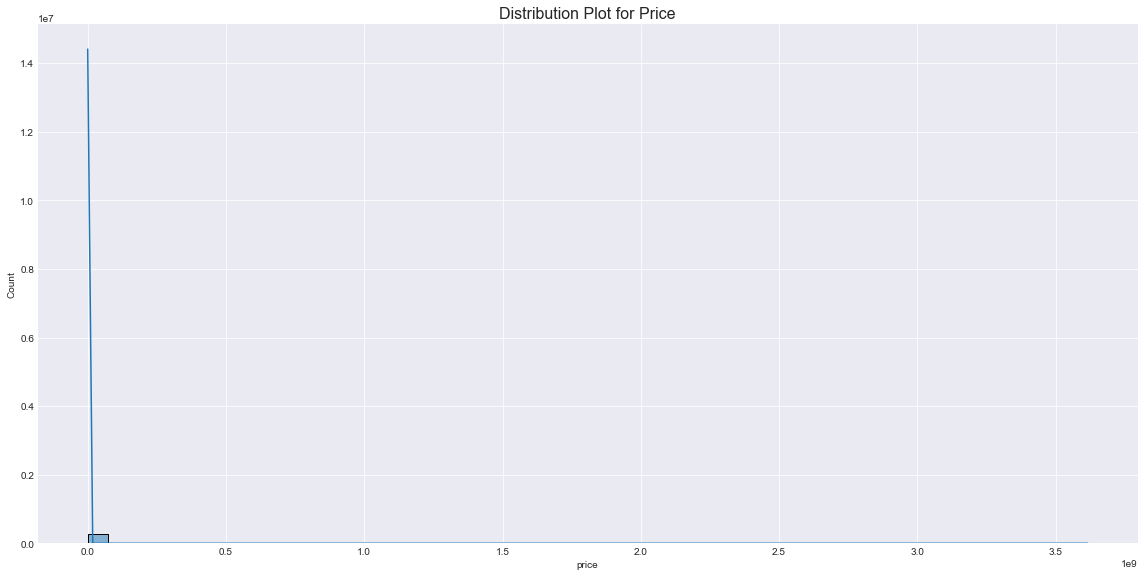

In [33]:
sns.displot(x=train_set.price, kde=True,  height=8, bins=50, aspect=2 )
plt.title("Distribution Plot for Price", fontsize=16)
plt.show()

### Drop outlier price records, with price less than $2,000 and more than 60,000

In [34]:
est = OutlierExtraction({"price":[2000, 60000]})
train_set = est.fit_transform(train_set)

In [35]:
train_set.price.describe()

count    244394.000000
mean      17850.377878
std       11934.564108
min        2000.000000
25%        7999.000000
50%       14990.000000
75%       25000.000000
max       60000.000000
Name: price, dtype: float64

### Year distribution after outlier removal

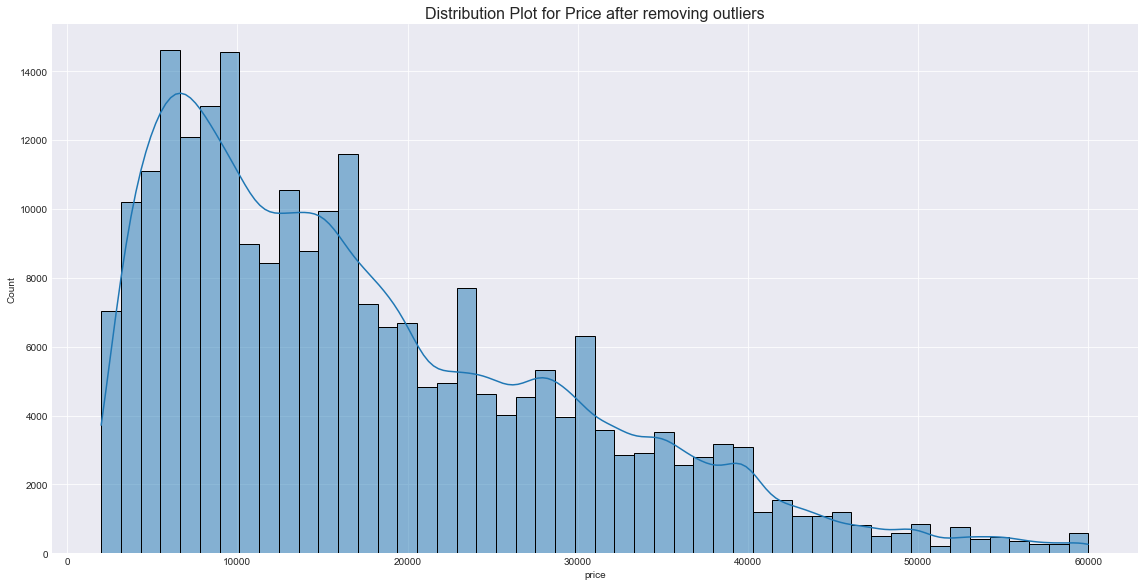

In [36]:
sns.displot(x=train_set.price, kde=True, height=8, bins=50, aspect=2 )
plt.title("Distribution Plot for Price after removing outliers", fontsize=16)
plt.show()

### Find Missing Values for all columns

In [37]:
train_set.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      5791
model             1234
condition        92712
cylinders            0
fuel              1739
odometer             0
title_status      1030
transmission      1045
VIN              76888
drive            59744
size            172494
type             43129
paint_color      58376
image_url            0
description         34
state                0
lat               1807
long              1807
posting_date         0
geometry             0
dtype: int64

### Find empty strings in cylinder columns
We will replace empty string with numpy.NAN so that we can replace while imputing values

In [38]:
print("Number of records with empty strings for cylinders column",  train_set.cylinders[train_set.cylinders == ""].count())

Number of records with empty strings for cylinders column 82256


### Create class that can be used in pipeline to replace blank values with NaN

In [39]:
class ReplaceBlankValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X):
        for col in X.columns: 
            ser = X[col]
            ser[ser == ""] = np.NaN
        return X

    def fit(self, X, y = None):
        return self

In [40]:
transfomer = ReplaceBlankValues()
train_set = pd.DataFrame(transfomer.fit_transform(train_set))
#df_temp.columns = train_set.columns
#train_set = df_temp

In [44]:
train_set.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      5791
model             1234
condition        92712
cylinders        82256
fuel              1739
odometer             0
title_status      1030
transmission      1045
VIN              76888
drive            59744
size            172494
type             43129
paint_color      58376
image_url            0
description         34
state                0
lat               1807
long              1807
posting_date         0
geometry             0
dtype: int64

### Bar plot of missing values of all columns to find columns with missing values more than 50%

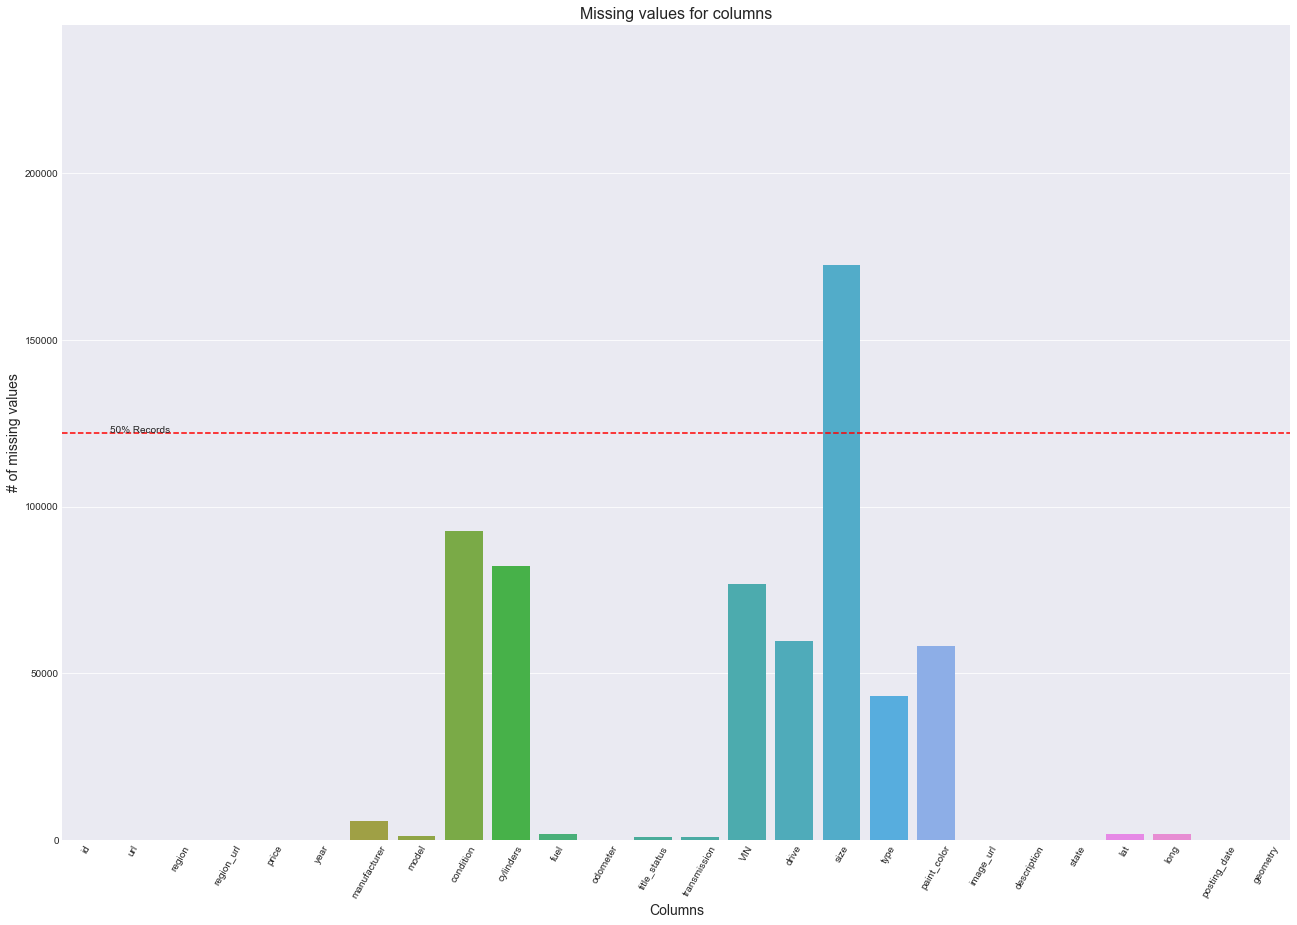

In [45]:
total = [len(train_set.index) for i in range(train_set.shape[1]) ]

fig, ax =plt.subplots(1,figsize=(22, 15))
g=sns.barplot(x=train_set.columns, y=train_set.isnull().sum())
ax1= g.axes
ax1.axhline(len(train_set.index)/2, ls='--', color="r")
ax1.text(0.5,len(train_set.index)/2, "50% Records")
plt.ylim(0, len(train_set.index))
plt.xticks(rotation=60)
plt.xlabel("Columns", fontsize=14)
plt.ylabel("# of missing values", fontsize=14)
plt.title("Missing values for columns", fontsize=16)
plt.show()

### We can drop column "size" as it has more than 50% missing values

In [46]:
train_set.drop(columns="size", inplace=True)
cat_attr.remove("size")

In [47]:
cat_attr

['region',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'paint_color',
 'state',
 'type']

### Convert categorical features to numeric using Label Encoder

### We are using OrdinalEncoder from sklearn >0.24, it doesn't throw exception when encounters new categories while predicting

In [50]:
class MyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.encoders = {}
        self.attributes = attributes

    def transform(self, df):
        X = df.copy()
        for cat in self.attributes:
            encoder = self.encoders[cat]
            nonulls = np.array(X[cat].dropna())
            impute_reshape = nonulls.reshape(-1,1)
            impute_ordinal = encoder.transform(impute_reshape)
            X[cat].loc[X[cat].notnull()] = np.squeeze(impute_ordinal)
        return X

    def fit(self, X, y = None):
        for cat in self.attributes:
            encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
            ser = X[cat].dropna()
            encoder.fit(ser.to_numpy().reshape(-1,1))
            self.encoders[cat] = encoder       
        return self


### Convert categorical values to numerical using ordinal encoding 

In [51]:
transformer = MyEncoder(cat_attr)
transformer.fit(train_set)

MyEncoder(attributes=['region', 'manufacturer', 'model', 'condition',
                      'cylinders', 'fuel', 'title_status', 'transmission',
                      'drive', 'paint_color', 'state', 'type'])

In [54]:
trans_df = transformer.transform(train_set)

In [55]:
trans_df[cat_attr].head(10)

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type
428050,169.0,16.0,3780.0,3.0,3.0,2.0,0.0,0.0,1.0,NaN,48.0,9.0
18887,105.0,13.0,18569.0,2.0,6.0,2.0,0.0,0.0,NaN,10.0,2.0,7.0
186119,44.0,30.0,13066.0,2.0,5.0,2.0,0.0,0.0,0.0,NaN,19.0,NaN
379234,96.0,30.0,18430.0,2.0,5.0,2.0,0.0,0.0,2.0,5.0,43.0,0.0
64763,374.0,30.0,17669.0,0.0,3.0,2.0,0.0,0.0,NaN,9.0,4.0,NaN
273084,42.0,4.0,18608.0,NaN,3.0,2.0,0.0,0.0,2.0,8.0,34.0,2.0
193169,49.0,7.0,4213.0,NaN,NaN,2.0,0.0,0.0,NaN,NaN,22.0,NaN
144582,31.0,7.0,15300.0,2.0,6.0,2.0,0.0,0.0,0.0,9.0,15.0,10.0
327153,275.0,33.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,9.0,37.0,8.0
256611,47.0,16.0,3780.0,NaN,3.0,2.0,0.0,0.0,1.0,8.0,31.0,9.0


### Impute missing values

In [57]:
imp_cols = np.append(num_attr, cat_attr)
imp_cols = np.append(imp_cols, ["price"])
trans_df[imp_cols].head()

,year,odometer,lat,long,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type,price
428050,2003.0,134578.0,43.118800,-87.947800,169.0,16.0,3780.0,3.0,3.0,2.0,0.0,0.0,1.0,NaN,48.0,9.0,3999
18887,2017.0,51031.0,36.203482,-94.138862,105.0,13.0,18569.0,2.0,6.0,2.0,0.0,0.0,NaN,10.0,2.0,7.0,47995
186119,2011.0,156300.0,41.673575,-70.266194,44.0,30.0,13066.0,2.0,5.0,2.0,0.0,0.0,0.0,NaN,19.0,NaN,6499
379234,2006.0,119000.0,31.817096,-106.561892,96.0,30.0,18430.0,2.0,5.0,2.0,0.0,0.0,2.0,5.0,43.0,0.0,5600
64763,2014.0,84000.0,34.226200,-118.447000,374.0,30.0,17669.0,0.0,3.0,2.0,0.0,0.0,NaN,9.0,4.0,NaN,5995


### Create new dataframe for columns that will be used while imputing

In [58]:
df_imputer = trans_df[imp_cols]

### Find good estimator to fill missing values

#### Iterative Imputers

In [59]:
# Estimate the score on the entire dataset by filling missing values by different iterative imputer
#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=random_state),
    ExtraTreesRegressor(n_estimators=10, random_state=random_state, n_jobs=15),
    KNeighborsRegressor(n_neighbors=5, n_jobs=15),
    Lasso(random_state=random_state)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti, random_state=random_state)
        df_new=df_imputer.copy()
        for col in tqdm(df_imputer.columns):
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
            
        X=df_new.iloc[:,:-1]
        y = np.ravel(df_imputer.iloc[:,-1:])
        
        X = X.fillna(X.median()).clip(-1e11,1e11)
        print("Calculating score for:",esti.__class__.__name__)
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error', n_jobs=12)

 47%|████▋     | 8/17 [00:00<00:00, 64.10it/s]

Estimating BayesianRidge


100%|██████████| 17/17 [00:00<00:00, 60.82it/s]


Calculating score for: BayesianRidge


 41%|████      | 7/17 [00:00<00:00, 63.26it/s]

Estimating DecisionTreeRegressor


100%|██████████| 17/17 [00:00<00:00, 60.26it/s]


Calculating score for: DecisionTreeRegressor


 41%|████      | 7/17 [00:00<00:00, 58.33it/s]

Estimating ExtraTreesRegressor


100%|██████████| 17/17 [00:00<00:00, 55.67it/s]


Calculating score for: ExtraTreesRegressor


 35%|███▌      | 6/17 [00:00<00:00, 55.54it/s]

Estimating KNeighborsRegressor


100%|██████████| 17/17 [00:00<00:00, 55.29it/s]


Calculating score for: KNeighborsRegressor


 35%|███▌      | 6/17 [00:00<00:00, 52.59it/s]

Estimating Lasso


100%|██████████| 17/17 [00:00<00:00, 54.69it/s]


Calculating score for: Lasso


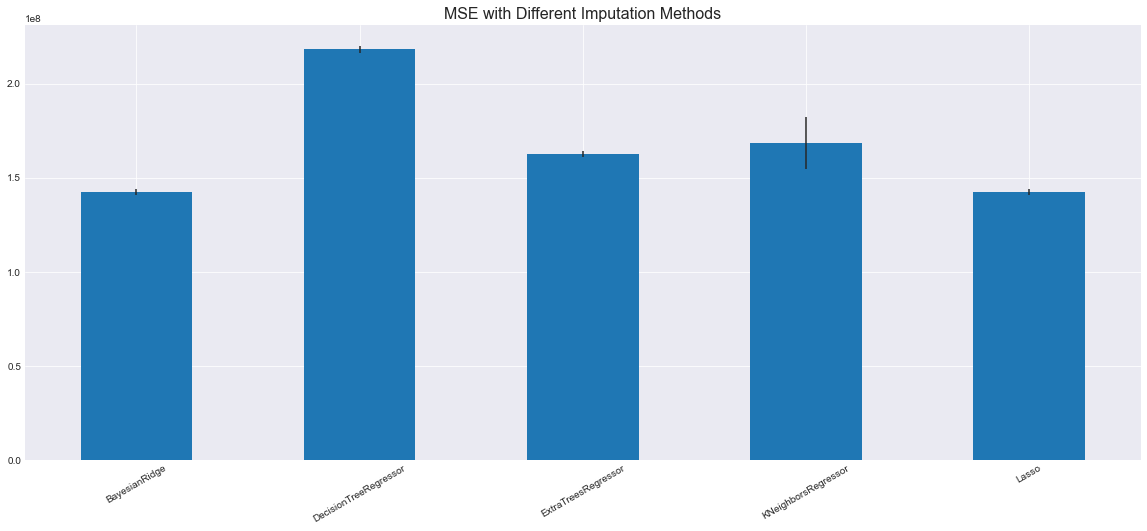



Method with Minimum Error Lasso


In [60]:
#ploting the graphs of scores each method
fig, ax =plt.subplots(1,figsize=(20, 8))
means = -score_iterative_imputer.mean()
errors = score_iterative_imputer.std()
means.plot(kind="bar", yerr=errors)
plt.xticks(rotation=30)
plt.title("MSE with Different Imputation Methods", fontsize=16)
plt.show()

print("\n\nMethod with Minimum Error", errors.idxmin())
name = errors.idxmin()

### Select Estimator for filling missing values

In [61]:
selected_est =  estimators[errors.argmin()]
print(selected_est)    

Lasso(random_state=17)


### Fill missing values Atrributes

In [62]:
df_imputer.isnull().sum()

year                0
odometer            0
lat              1807
long             1807
region              0
manufacturer     5791
model            1234
condition       92712
cylinders       82256
fuel             1739
title_status     1030
transmission     1045
drive           59744
paint_color     58376
state               0
type            43129
price               0
dtype: int64

In [63]:
independent_vars = np.append(num_attr, cat_attr)
imputer=IterativeImputer(selected_est) 
imputed_data=imputer.fit_transform(df_imputer[independent_vars], df_imputer["price"])
df_imputer[independent_vars]=imputed_data
df_imputer.head()

,year,odometer,lat,long,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type,price
428050,2003.0,134578.0,43.118800,-87.947800,169.0,16.0,3780.0,3.0,3.0,2.0,0.0,0.0,1.000000,5.586651,48.0,9.000000,3999
18887,2017.0,51031.0,36.203482,-94.138862,105.0,13.0,18569.0,2.0,6.0,2.0,0.0,0.0,0.580311,10.000000,2.0,7.000000,47995
186119,2011.0,156300.0,41.673575,-70.266194,44.0,30.0,13066.0,2.0,5.0,2.0,0.0,0.0,0.000000,5.530187,19.0,5.826726,6499
379234,2006.0,119000.0,31.817096,-106.561892,96.0,30.0,18430.0,2.0,5.0,2.0,0.0,0.0,2.000000,5.000000,43.0,0.000000,5600
64763,2014.0,84000.0,34.226200,-118.447000,374.0,30.0,17669.0,0.0,3.0,2.0,0.0,0.0,0.587069,9.000000,4.0,5.530064,5995


### Check if there are more missing values

In [64]:
df_imputer.isnull().sum()

year            0
odometer        0
lat             0
long            0
region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
paint_color     0
state           0
type            0
price           0
dtype: int64

### Add age column from model year and posting date
We are considering September month of previous year of model launch year to calculate age of the vehicle in months.

In [65]:
class AddAgeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, year_col_idx, posting_date_idx): # no *args or **kargs
        self.year_col_idx = year_col_idx
        self.posting_date_idx = posting_date_idx
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        inp = X.values
        year = (inp[:, self.year_col_idx] - 1).astype(int).astype(str)
        manu_year=np.char.add(year, "/09/30")
        manu_date = pd.Series(pd.to_datetime(manu_year, format="%Y/%m/%d", utc=True))
        ser = pd.Series(inp[:, self.posting_date_idx])
        #print(ser.dtypes)
        diff = pd.to_datetime(ser).subtract(manu_date)
        #print(diff)
        return np.c_[(diff/np.timedelta64(1, 'M'))]
  

In [66]:
attr_adder = AddAgeColumn(train_set.columns.get_loc("year"), train_set.columns.get_loc("posting_date"))
age_col = attr_adder.transform(train_set)

In [67]:
df_imputer["age_in_months"] = age_col
df_imputer.head()

,year,odometer,lat,long,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type,price,age_in_months
428050,2003.0,134578.0,43.118800,-87.947800,169.0,16.0,3780.0,3.0,3.0,2.0,0.0,0.0,1.000000,5.586651,48.0,9.000000,3999,217.982963
18887,2017.0,51031.0,36.203482,-94.138862,105.0,13.0,18569.0,2.0,6.0,2.0,0.0,0.0,0.580311,10.000000,2.0,7.000000,47995,49.240977
186119,2011.0,156300.0,41.673575,-70.266194,44.0,30.0,13066.0,2.0,5.0,2.0,0.0,0.0,0.000000,5.530187,19.0,5.826726,6499,121.488248
379234,2006.0,119000.0,31.817096,-106.561892,96.0,30.0,18430.0,2.0,5.0,2.0,0.0,0.0,2.000000,5.000000,43.0,0.000000,5600,182.046879
64763,2014.0,84000.0,34.226200,-118.447000,374.0,30.0,17669.0,0.0,3.0,2.0,0.0,0.0,0.587069,9.000000,4.0,5.530064,5995,85.282226


### distribution plot for age in months

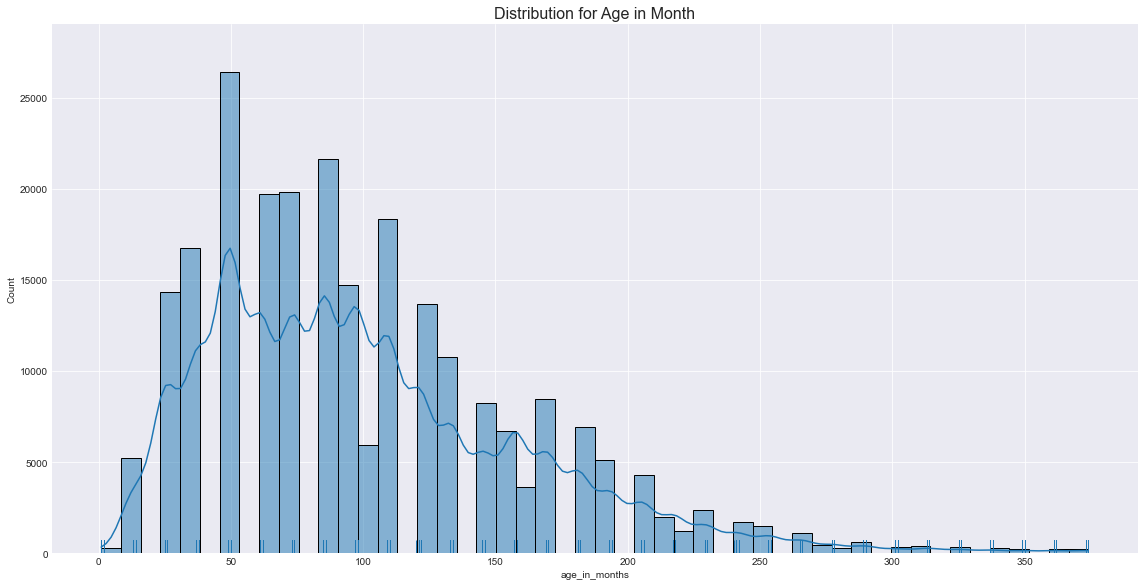

In [68]:
sns.displot(x=df_imputer.age_in_months.astype(int), kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.title("Distribution for Age in Month", fontsize=16)
plt.show()

### Feature selection

In [69]:
plt.figure(figsize=(16,8))
cols = [col for col in df_imputer.columns if col != "price" and col != "year"]
cols.append("price")
cor = df_imputer[cols].corr()
cor.style.background_gradient(cmap='coolwarm')

,odometer,lat,long,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type,age_in_months,price
odometer,1.000000,0.036273,0.058490,0.011871,-0.022259,0.004290,-0.291756,-0.041842,-0.059359,-0.021937,-0.277824,-0.074541,-0.002919,0.032230,-0.027289,0.552442,-0.535019
lat,0.036273,1.000000,-0.132743,-0.100749,-0.020516,0.014692,-0.034348,-0.019298,-0.026425,-0.015614,-0.064175,-0.206489,-0.019450,0.213750,-0.020969,0.004934,0.002392
long,0.058490,-0.132743,1.000000,0.032237,-0.024444,0.008214,0.089654,0.052288,0.003050,-0.019658,0.079169,0.024597,-0.034663,0.248795,0.018535,0.053175,-0.087094
region,0.011871,-0.100749,0.032237,1.000000,0.011964,-0.002932,0.001780,-0.003287,0.002393,-0.003039,-0.000368,0.022026,0.000245,-0.032322,0.006867,0.021232,-0.021753
manufacturer,-0.022259,-0.020516,-0.024444,0.011964,1.000000,-0.004760,0.008233,-0.222257,-0.025039,0.009534,0.039825,-0.075572,-0.008438,-0.011984,0.062734,-0.017445,-0.033969
model,0.004290,0.014692,0.008214,-0.002932,-0.004760,1.000000,0.007441,0.083749,0.061693,-0.019060,0.031555,-0.188291,0.004273,0.007316,-0.120345,-0.028393,0.035941
condition,-0.291756,-0.034348,0.089654,0.001780,0.008233,0.007441,1.000000,0.099456,0.046395,-0.005633,0.224665,0.063741,0.001545,0.017605,0.053856,-0.152676,0.183191
cylinders,-0.041842,-0.019298,0.052288,-0.003287,-0.222257,0.083749,0.099456,1.000000,-0.038083,-0.066475,0.116735,-0.031723,0.023427,0.011205,0.026645,0.056109,0.343670
fuel,-0.059359,-0.026425,0.003050,0.002393,-0.025039,0.061693,0.046395,-0.038083,1.000000,-0.001183,0.067841,0.024074,-0.038091,-0.020864,-0.058731,-0.066197,-0.149593
title_status,-0.021937,-0.015614,-0.019658,-0.003039,0.009534,-0.019060,-0.005633,-0.066475,-0.001183,1.000000,-0.040805,0.000704,-0.013139,0.013272,0.000808,-0.008522,-0.090540


<Figure size 1152x576 with 0 Axes>

### We can also drop "State" column as correlation shows it's not highly correlated to price

In [70]:
independent_vars = [col for col in independent_vars if col != "state"]

### Columns Selector

In [89]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
num_sel = ColumnSelector(num_attr)
#df_num_attrs = num_sel.transform(df_sel)

In [73]:
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, est, independent_vars, target_var):
        self.est = est
        self.independent_vars = independent_vars
        self.target_var = target_var
    def fit(self, X, y=None):
        self.imputer = IterativeImputer(self.est) 
        self.imputer.fit(X[self.independent_vars], X[self.target_var])
        return self
    def transform(self, X):
        df_imp = X.copy()
        imputed_data = self.imputer.transform(X[self.independent_vars])
        df_imp[self.independent_vars]=imputed_data
        return df_imp


### Fulll Pipeline 

#### Outlier removal pipeline with following columns and limits
* 1 price: [2_000, 60_000]
* 2 year: [1990, 2021]
* 3 odometer: [0, 170_000]
* 4 lat:[25, 50],
* 5 long:[-125, -65]}))]

In [74]:
outlier_removal = Pipeline([('outlier-removal', OutlierExtraction({"price":[2_000, 60_000], 
                                                                   "year":[1990, 2021],
                                                                   "odometer":[0, 170_000],
                                                                   "lat":[25, 50],
                                                                   "long":[-125, -65]}))])

#### Pipeline for standard Scale

In [75]:
standard_scaler = StandardScaler()

#### Pipeline for Existing features
* 1 Replace Blank values with np.NaN
* 2 Ordinal Encoding
* 3 Imputer to fill missing values
* 4 Column selection

In [88]:
pipeline_existing_cols = Pipeline([('replace-blank-with_NaN', ReplaceBlankValues()),
                                ('label-encoding',MyEncoder(cat_attr)),# MyLabelEncoder(cat_attr)),
                                ('imputer', Imputer(selected_est, independent_vars, "price")),
                                ('column-selector', ColumnSelector(independent_vars)),
                                ])

#### Pipeline for adding new column age from year and posting date

In [77]:
pipeline_add_age = Pipeline([
                             ('add-age', AddAgeColumn(train_set_copy.columns.get_loc("year"), train_set_copy.columns.get_loc("posting_date")))
                            ])

#### Pipeline to combine existing columns and new created columns

In [78]:
feature_union = FeatureUnion(transformer_list=[
        ("existing_column", pipeline_existing_cols),
        ("added_cols", pipeline_add_age)
    ])

#### Full Pipeline

In [79]:
full_pipeline = Pipeline([("outlier_removal", outlier_removal),
                           ("transformation", feature_union),
                           ("scaling", StandardScaler()) 
                           ], verbose=True)

#### Pipeline for Target variable price

In [80]:
target_col_pipeline = Pipeline([("outlier_removal", outlier_removal),
                           ("column-selector", ColumnSelector(['price']))], verbose=True)

### Transform training Dataset with pipeline

In [81]:
train_copy_df = train_set_copy.copy()
train_X = full_pipeline.fit_transform(train_set_copy)
train_X.shape

[Pipeline] ... (step 1 of 3) Processing outlier_removal, total=   0.4s
[Pipeline] .... (step 2 of 3) Processing transformation, total=   5.3s
[Pipeline] ........... (step 3 of 3) Processing scaling, total=   0.0s


(238195, 16)

In [82]:
train_Y = target_col_pipeline.fit_transform(train_copy_df)
train_Y.shape

[Pipeline] ... (step 1 of 2) Processing outlier_removal, total=   0.4s
[Pipeline] ... (step 2 of 2) Processing column-selector, total=   0.0s


(238195, 1)

### Transform Test Dataset with Pipeline

In [83]:
test_df = test_set.copy()
test_X = full_pipeline.transform(test_df)
test_Y = target_col_pipeline.transform(test_df)

### Save Training dataset into CSV

In [84]:
cols = np.append(independent_vars, "age_in_months")
df = pd.DataFrame(train_X, columns=cols)
df.to_csv("train_X.csv", index=True)

### Save Training dataset Target variable in CSV

In [85]:
cols = ["price"]
df = pd.DataFrame(train_Y, columns=cols)
df.to_csv("train_Y.csv", index=True)

### Save Test Data into CSV

In [86]:
cols = np.append(independent_vars, "age_in_months")
df = pd.DataFrame(test_X, columns=cols)
df.to_csv("test_X.csv", index=True)

### Save Target variable from Test Dataset into CSV to use for model evaluation

In [87]:
cols = ["price"]
df = pd.DataFrame(test_Y, columns=cols)
df.to_csv("test_Y.csv", index=True)